# Project 2 - INF264
*By Kim Austgulen and Fillip Lampe*

Short overview on this file, this will mainly focus on the results and the basis of what we will write in our report. As we want to keep this file more clean, we have most of the code move into our import files.

In [1]:
import numpy as np

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

every split is seeded so we split the X and y in their respective classes. We did it this way so this file will be more clean

## Task 1: 

In [4]:
# this will take around 7-8 min depending on the machine
# our SVM model class
from svm import SVM

# it will split the data and preprocess it
n = 1 # 5# number of intervals for the rand search
folds = 3 # number of folds for cross validation

# this will by deafult not use pca
svm = SVM(X, y, n, folds,seed=seed)
svm.fit()
svm_eval_info = svm.evaluate()


Starting training...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  20.3s
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  18.1s
[CV] END C=75.55750309950135, coef0=0.009839217559140079, degree=3, gamma=0.0010316674691784767, kernel=rbf, shrinking=True; total time=  15.6s
---------- training is finished. ----------

Random Search took 77.50 seconds
Best Parameters: {'shrinking': True, 'kernel': 'rbf', 'gamma': 0.0010316674691784767, 'degree': 3, 'coef0': 0.009839217559140079, 'C': 75.55750309950135}
Accuracy: 0.9105


In [5]:
# print the results
print("SVM")
print(svm_eval_info[2])

SVM
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        92
           1       0.92      0.94      0.93        47
           2       0.84      0.94      0.88        65
           3       0.92      0.90      0.91       136
           4       0.93      0.84      0.88        77
           5       0.93      0.96      0.94        96
           6       0.95      0.94      0.94       133
           7       0.92      0.94      0.93        99
           8       0.79      0.85      0.82        73
           9       0.88      0.88      0.88        32
          10       0.96      0.94      0.95       126
          11       0.76      0.70      0.73        80
          12       0.99      0.97      0.98       139
          13       0.95      0.90      0.92       153
          14       0.67      0.73      0.70        11
          15       0.88      0.91      0.90        58
          16       0.98      1.00      0.99        58

    accuracy          

In [6]:
# Our CNN models (PyTorch)
from pytorch_cnn import CNN_PT

#params must not be changed if you are gonna load the model
n = 5 # number of intervals for the rand search
folds = 3 # number of folds for cross validation
epochs = 10 # number of epochs for training
batch_size = 32 # batch size for training
path = '../other/' # path to save the models

# fit is removed as it is not reproducable
lenet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='lenet')
#lenet_cnn_pt.fit() # remove if you wanat to train the model
lenet_eval_info = lenet_cnn_pt.evaluate(load=True)

# fair warning this takes a while
# fit is removed as it is not reproducable
alexnet_cnn_pt = CNN_PT(X, y, folds, seed, epochs, batch_size, path, model='alexnet')
#alexnet_cnn_pt.fit() # remove if you wanat to train the model
alexnet_eval_info = alexnet_cnn_pt.evaluate(load=True)


Evaluating model on validation data...
Average loss: 0.0037, Accuracy: 0.9593
Evaluating model on validation data...
Average loss: 0.0033, Accuracy: 0.9559


In [7]:
# print the lenet results
print("LeNet with PyTorch")
print(lenet_eval_info[2])

LeNet with PyTorch
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        92
           1       1.00      0.98      0.99        47
           2       0.95      0.94      0.95        65
           3       0.99      0.97      0.98       136
           4       0.97      0.97      0.97        77
           5       0.93      1.00      0.96        96
           6       0.99      0.98      0.98       133
           7       0.97      0.99      0.98        99
           8       0.97      0.95      0.96        73
           9       0.97      0.97      0.97        32
          10       1.00      0.97      0.98       126
          11       0.90      0.96      0.93        80
          12       0.99      0.89      0.94       139
          13       0.96      0.94      0.95       153
          14       0.56      0.91      0.69        11
          15       1.00      0.93      0.96        58
          16       1.00      1.00      1.00        58

    acc

In [8]:
print("AlexNet with PyTorch")
print(alexnet_eval_info[2])

AlexNet with PyTorch
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        92
           1       0.92      1.00      0.96        47
           2       0.93      0.97      0.95        65
           3       0.98      0.97      0.97       136
           4       0.96      0.96      0.96        77
           5       0.96      1.00      0.98        96
           6       0.97      0.99      0.98       133
           7       0.99      0.99      0.99        99
           8       0.93      0.90      0.92        73
           9       0.91      1.00      0.96        32
          10       0.98      0.97      0.97       126
          11       0.97      0.76      0.85        80
          12       0.96      0.96      0.96       139
          13       0.94      0.93      0.93       153
          14       0.77      0.91      0.83        11
          15       0.97      0.98      0.97        58
          16       1.00      1.00      1.00        58

    a

In [9]:
from random_forest import RandomForest

folds = 3 # number of folds for cross validation
n = 1 # 5 # number of intervals for the
bagging_n = 2 

randomforest = RandomForest(X, y, n, folds, seed)
randomforest.fit()
randomforest_eval_info = randomforest.evaluate()

---------- training RandomForest model ----------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=103; total time=  12.2s
---------- training is finished. ----------

Random Search took 55.71 seconds
Best Parameters: {'n_estimators': 103, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Accuracy: 0.8773


In [10]:
# rf results
print("Random Forest")
print(randomforest_eval_info[2])

Random Forest
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        92
           1       0.87      0.96      0.91        47
           2       0.86      0.92      0.89        65
           3       0.90      0.91      0.91       136
           4       0.88      0.82      0.85        77
           5       0.94      0.95      0.94        96
           6       0.94      0.91      0.92       133
           7       0.93      0.91      0.92        99
           8       0.85      0.77      0.81        73
           9       0.71      0.84      0.77        32
          10       0.88      0.86      0.87       126
          11       0.74      0.69      0.71        80
          12       0.93      0.91      0.92       139
          13       0.94      0.88      0.91       153
          14       0.45      0.82      0.58        11
          15       0.73      0.78      0.75        58
          16       0.97      1.00      0.98        58

    accuracy

In [11]:
from keras_cnn import CNN_KERAS

epochs = 6 # number of epochs for training
path = '../other/' # path to save the models

# To retrain models from scracth, set retrain = True, and un-comment the .fit function
# WARNING: This process is SLOW! Especially for AlexNet.

lenet_cnn_keras = CNN_KERAS(
    X=X,
    y=y,
    seed=seed,
    epochs=epochs,
    path=path,
    threshold=.85,
    retrain=False,
    model='lenet'
)
# Commented out to avoid re-training.
#lenet_cnn_keras.fit()

alexnet_cnn_keras = CNN_KERAS(
    X=X,
    y=y,
    seed=seed,
    epochs=epochs,
    path=path,
    threshold=.5,
    retrain=False,
    model='alexnet'
)
# Commented out to avoid re-training. 
#alexnet_cnn_keras.fit()

# Evaluate the models
# If load = True, use pretrained best model
# NOTE: if load = False, use newly trained model. Set retrain = True, and uncomment .fit for this.


lenet_cnn_keras_eval_info = lenet_cnn_keras.evaluate(load=True)
alexnet_cnn_keras_eval_info = alexnet_cnn_keras.evaluate(load=True)

Loading Pretrained LeNet Model:

47/47 [==============================] - 1s 16ms/step - loss: 0.1031 - accuracy: 0.9736

 LeNet Model accuracy on validation data : 0.9736, with loss:0.1031
47/47 [==============================] - 1s 16ms/step
Loading Pretrained AlexNet Model:

47/47 [==============================] - 2s 38ms/step - loss: 0.2434 - accuracy: 0.9539

 AlexNet Model accuracy on validation data : 0.9539, with loss:0.2434
47/47 [==============================] - 2s 37ms/step


In [12]:
# print the results for lenet keras
print("LeNet with Keras")
print(lenet_cnn_keras_eval_info[2])

LeNet with Keras
              precision    recall  f1-score   support

           0       0.95      0.88      0.92        92
           1       1.00      1.00      1.00        47
           2       0.95      0.97      0.96        65
           3       0.99      0.99      0.99       136
           4       0.97      0.99      0.98        77
           5       1.00      0.99      0.99        96
           6       0.97      1.00      0.99       133
           7       0.99      0.99      0.99        99
           8       0.97      0.96      0.97        73
           9       0.97      1.00      0.98        32
          10       0.99      0.98      0.98       126
          11       0.96      0.93      0.94        80
          12       0.99      0.99      0.99       139
          13       0.94      0.96      0.95       153
          14       0.83      0.91      0.87        11
          15       0.97      0.97      0.97        58
          16       1.00      1.00      1.00        58

    accur

In [13]:
print("AlexNet with Keras")
print(alexnet_cnn_keras_eval_info[2])

AlexNet with Keras
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        92
           1       1.00      0.98      0.99        47
           2       0.93      0.95      0.94        65
           3       0.99      1.00      0.99       136
           4       0.98      0.84      0.91        77
           5       0.96      1.00      0.98        96
           6       0.99      0.92      0.95       133
           7       0.97      0.99      0.98        99
           8       0.92      0.92      0.92        73
           9       0.91      0.94      0.92        32
          10       0.94      0.97      0.95       126
          11       0.96      0.86      0.91        80
          12       0.99      1.00      1.00       139
          13       0.95      0.93      0.94       153
          14       0.82      0.82      0.82        11
          15       0.87      1.00      0.93        58
          16       1.00      1.00      1.00        58

    acc

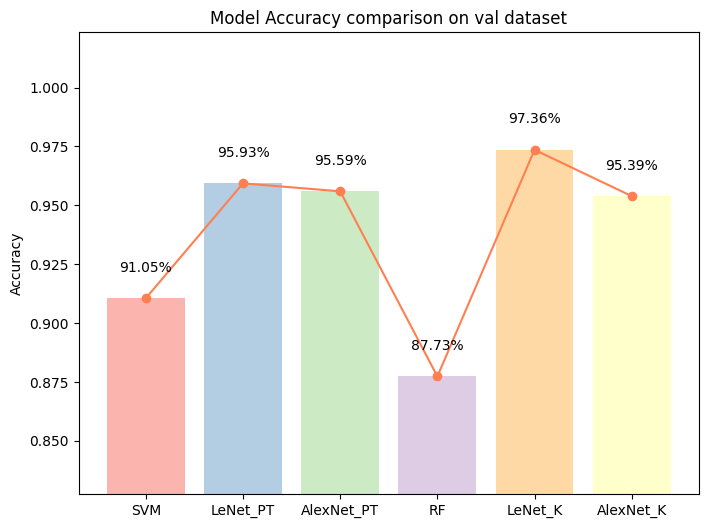

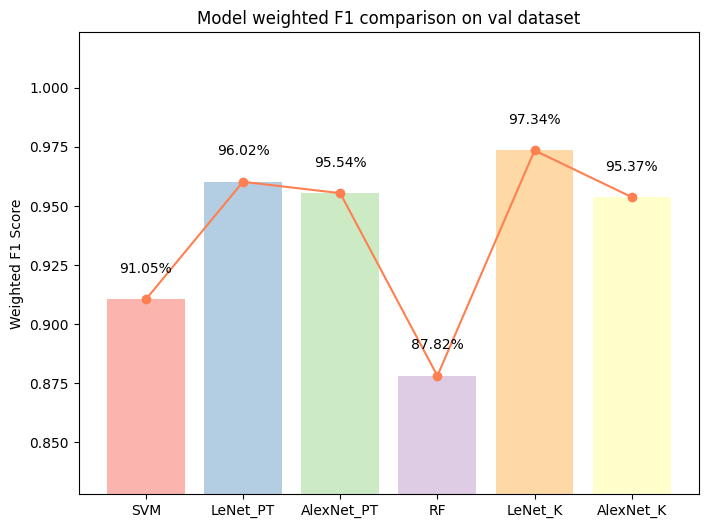

In [14]:
from visiualising import compare_model_accuracy

labels = ['SVM', 'LeNet_PT', 'AlexNet_PT', 'RF', 'LeNet_K', 'AlexNet_K']
compare_model_accuracy(
    "Model Accuracy comparison on val dataset",
    labels,
    "Accuracy",
    svm_eval_info[1], 
    lenet_eval_info[1], 
    alexnet_eval_info[1],
    randomforest_eval_info[1],
    lenet_cnn_keras_eval_info[1],
    alexnet_cnn_keras_eval_info[1],
    )

compare_model_accuracy(
    "Model weighted F1 comparison on val dataset",
    labels,
    "Weighted F1 Score",
    svm_eval_info[3],
    lenet_eval_info[3],
    alexnet_eval_info[3],
    randomforest_eval_info[3],
    lenet_cnn_keras_eval_info[3],
    alexnet_cnn_keras_eval_info[3],
    )


In [15]:
# Extract the f1 values
accuracies = {
    'SVM': svm_eval_info[3],
    'LeNet_PT': lenet_eval_info[3],
    'AlexNet_PT': alexnet_eval_info[3],
    'Random Forest': randomforest_eval_info[3],
    'LeNet_Keras': lenet_cnn_keras_eval_info[3],
    'AlexNet_Keras': alexnet_cnn_keras_eval_info[3]
}

# Find the model with the best f1 score
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

print(f"The model with the best f1 score is {best_model} with an score of {best_accuracy:.2f}")

The model with the best f1 score is LeNet_Keras with an score of 0.97


Small differences in hardware, like using different CPUs, can result in slightly different floating-point arithmetic, affecting model performance across runs. Due to these reproducability issues it is better to choose svm 

### Final Test:

Accuracy: 0.9207


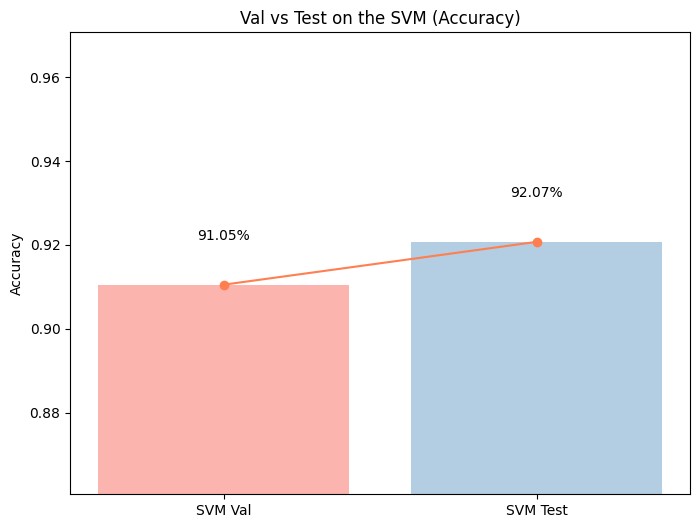

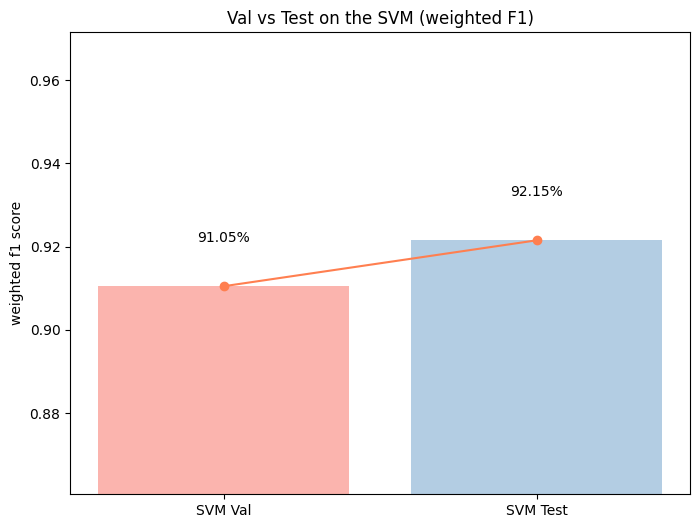

In [16]:
#Val vs Test on our best final model (SVM)
svm_test_info = svm.test()

labels = ["SVM Val", "SVM Test"]
compare_model_accuracy("Val vs Test on the SVM (Accuracy)", labels, "Accuracy", svm_eval_info[1], svm_test_info[1])

compare_model_accuracy("Val vs Test on the SVM (weighted F1)", labels, "weighted f1 score", svm_eval_info[3], svm_test_info[3])

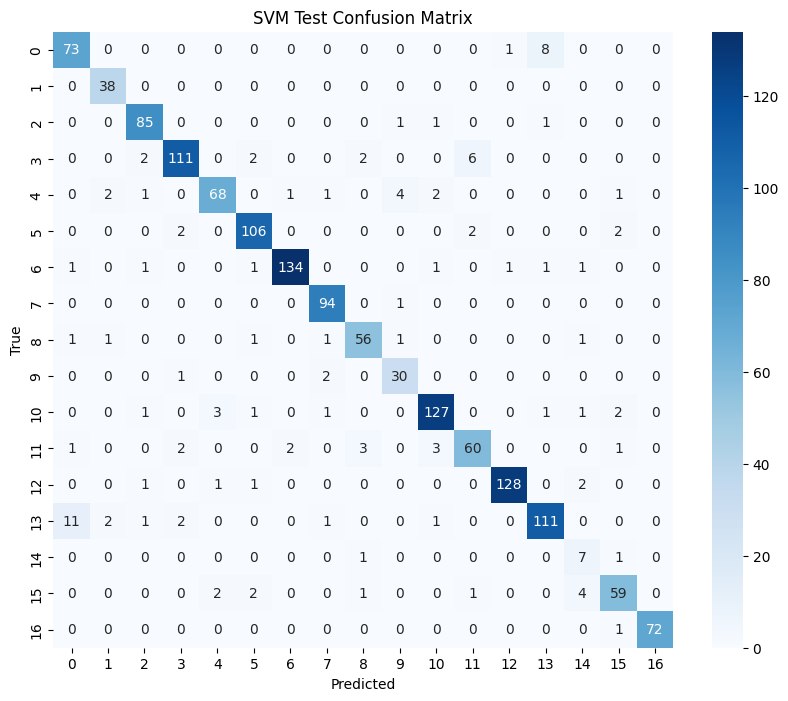

In [17]:
from visiualising import visualize_confusion_matrix
# comfusion matrix
visualize_confusion_matrix(svm_test_info[4], svm_test_info[0], "SVM Test Confusion Matrix")

## Task 2:

In [18]:
# Our SVM model with PCA
n = 1 # 3 # number of intervals for the rand search
folds = 3 # number of folds for cross validation
pca_n = 1 # 3 # number of pca components it will test

svm_pca = SVM(X, y, n, folds, pca_n, seed=seed, pca=True)
svm_pca.fit()
svm_pca_eval_info = svm_pca.evaluate()
svm_pca_test_info = svm_pca.test()

Starting PCA training...

--Training with 0.90 components 1/1--
Data went from (11747, 576) to (11747, 158)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   5.3s
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   5.1s
[CV] END C=73.8459779302997, coef0=0.7790496653525528, degree=2, gamma=0.01135265110257893, kernel=poly, shrinking=True; total time=   4.8s
Random Search for 0.90 took 24.48 s
---------- training is finished. ----------

PCA training took 24.67 seconds
Best Parameters: {'C': 73.8459779302997, 'coef0': 0.7790496653525528, 'degree': 2, 'gamma': 0.01135265110257893, 'kernel': 'poly', 'shrinking': True} and best n_components: 0.9
Accuracy: 0.9112
Accuracy: 0.9262


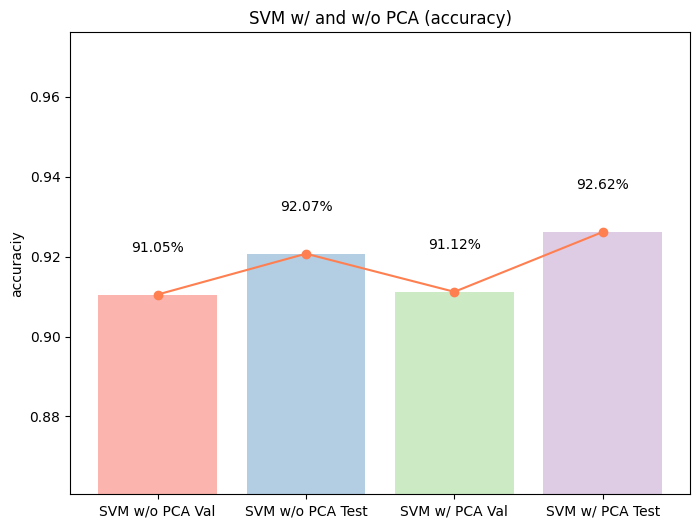

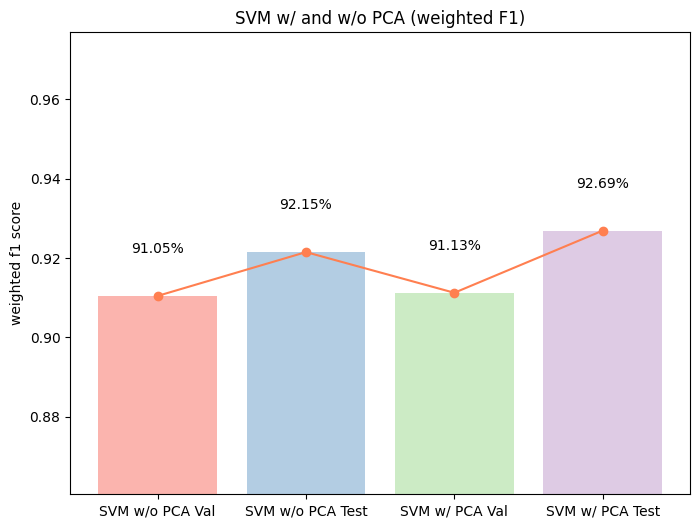

In [19]:
labels = ["SVM w/o PCA Val", "SVM w/o PCA Test", "SVM w/ PCA Val", "SVM w/ PCA Test"]
compare_model_accuracy(
    "SVM w/ and w/o PCA (accuracy)", 
    labels,
    "accuraciy",
    svm_eval_info[1],
    svm_test_info[1], 
    svm_pca_eval_info[1], 
    svm_pca_test_info[1])

compare_model_accuracy(
    "SVM w/ and w/o PCA (weighted F1)", 
    labels,
    "weighted f1 score",
    svm_eval_info[3],
    svm_test_info[3], 
    svm_pca_eval_info[3], 
    svm_pca_test_info[3])

## Task 3:

In [20]:
dataset = np.load('../data/corrupt_dataset.npz')
X2 = dataset['X']

### Guassian Clustering of the data

In [21]:
from ood_detection import OODDetection

ood_detector = OODDetection(
    best_svc=svm_pca.best_model, 
    best_pca=svm_pca.best_pca, 
    X_train_pca=svm_pca.X_train_pca,
    y_train=svm_pca.y_train,
    scaler=svm_pca.scaler,
    seed=seed,
    n_components=17,
    use_probs=False # this will determine if it will use the SVM's prediction or just features
    )

X2_transformed = ood_detector.fit(X2)

g_odd_indices, g_total_odd_indices = ood_detector.detect_ood_gaussian(X2_transformed)

ood_indices_mahalanobis, num_ood_mahalanobis = ood_detector.detect_ood_mahalanobis(X2_transformed)

GaussianMixture model with 17 components fitted on training data.
Number of OOD samples: 52
Number of OOD samples (Mahalanobis): 66


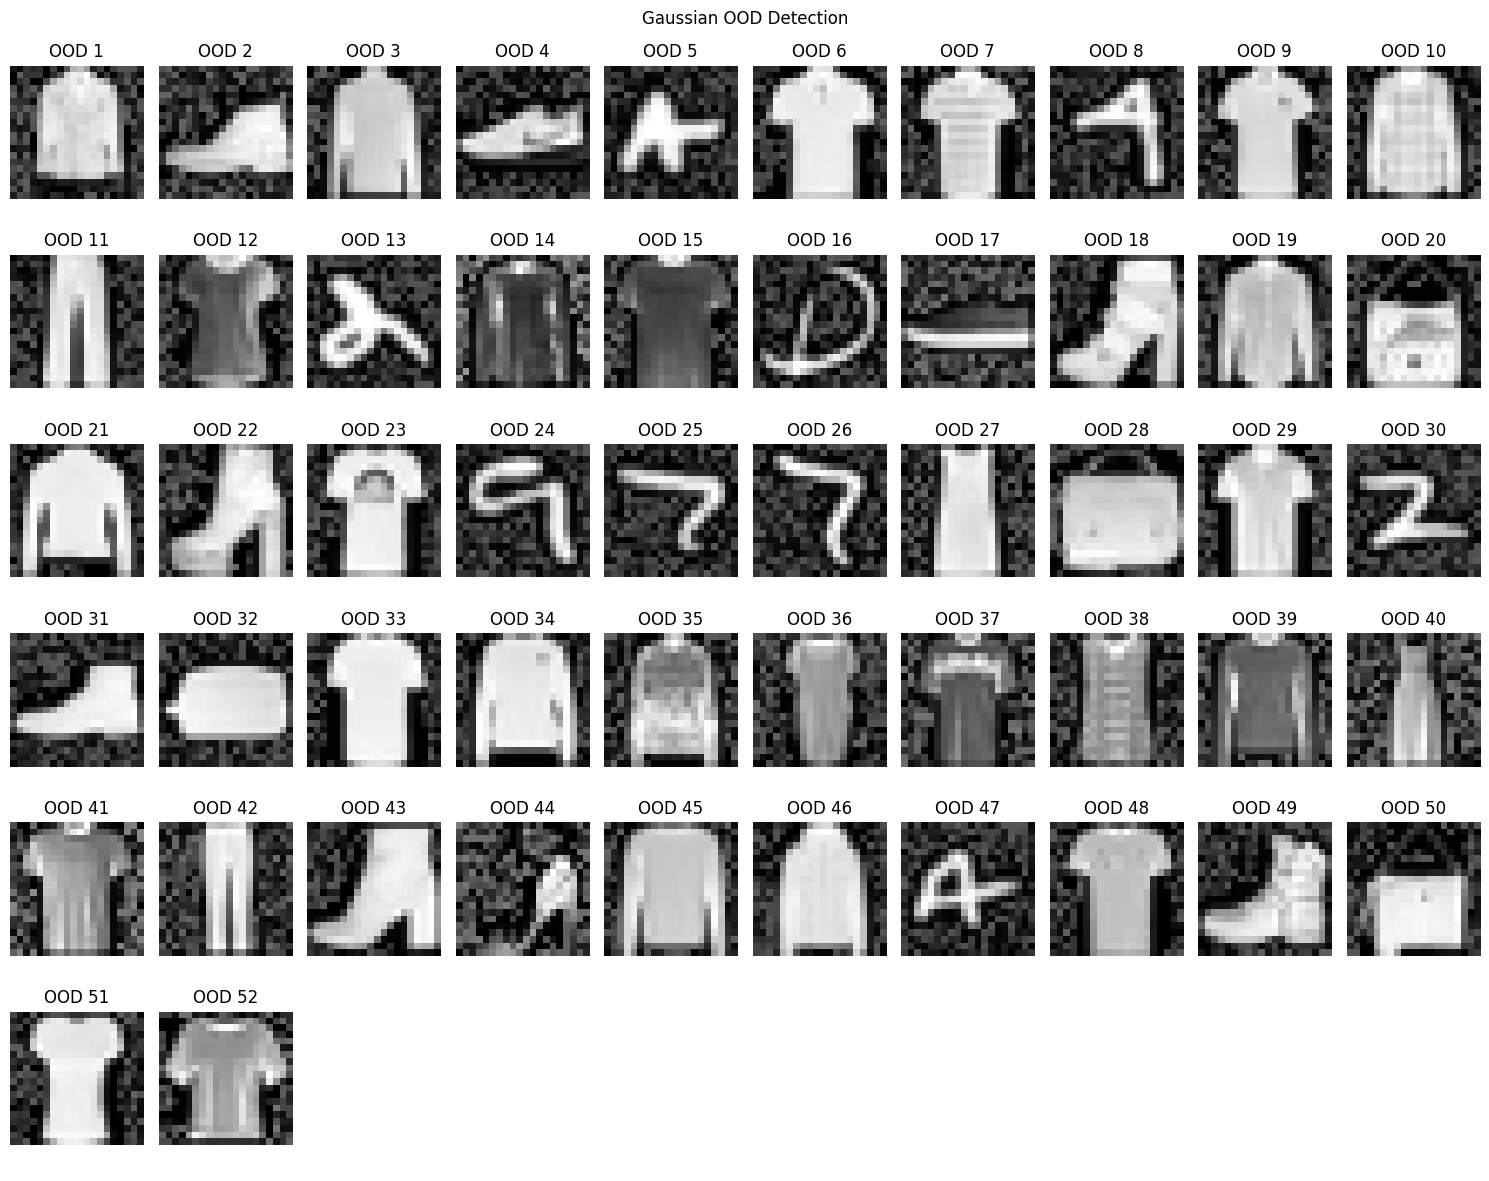

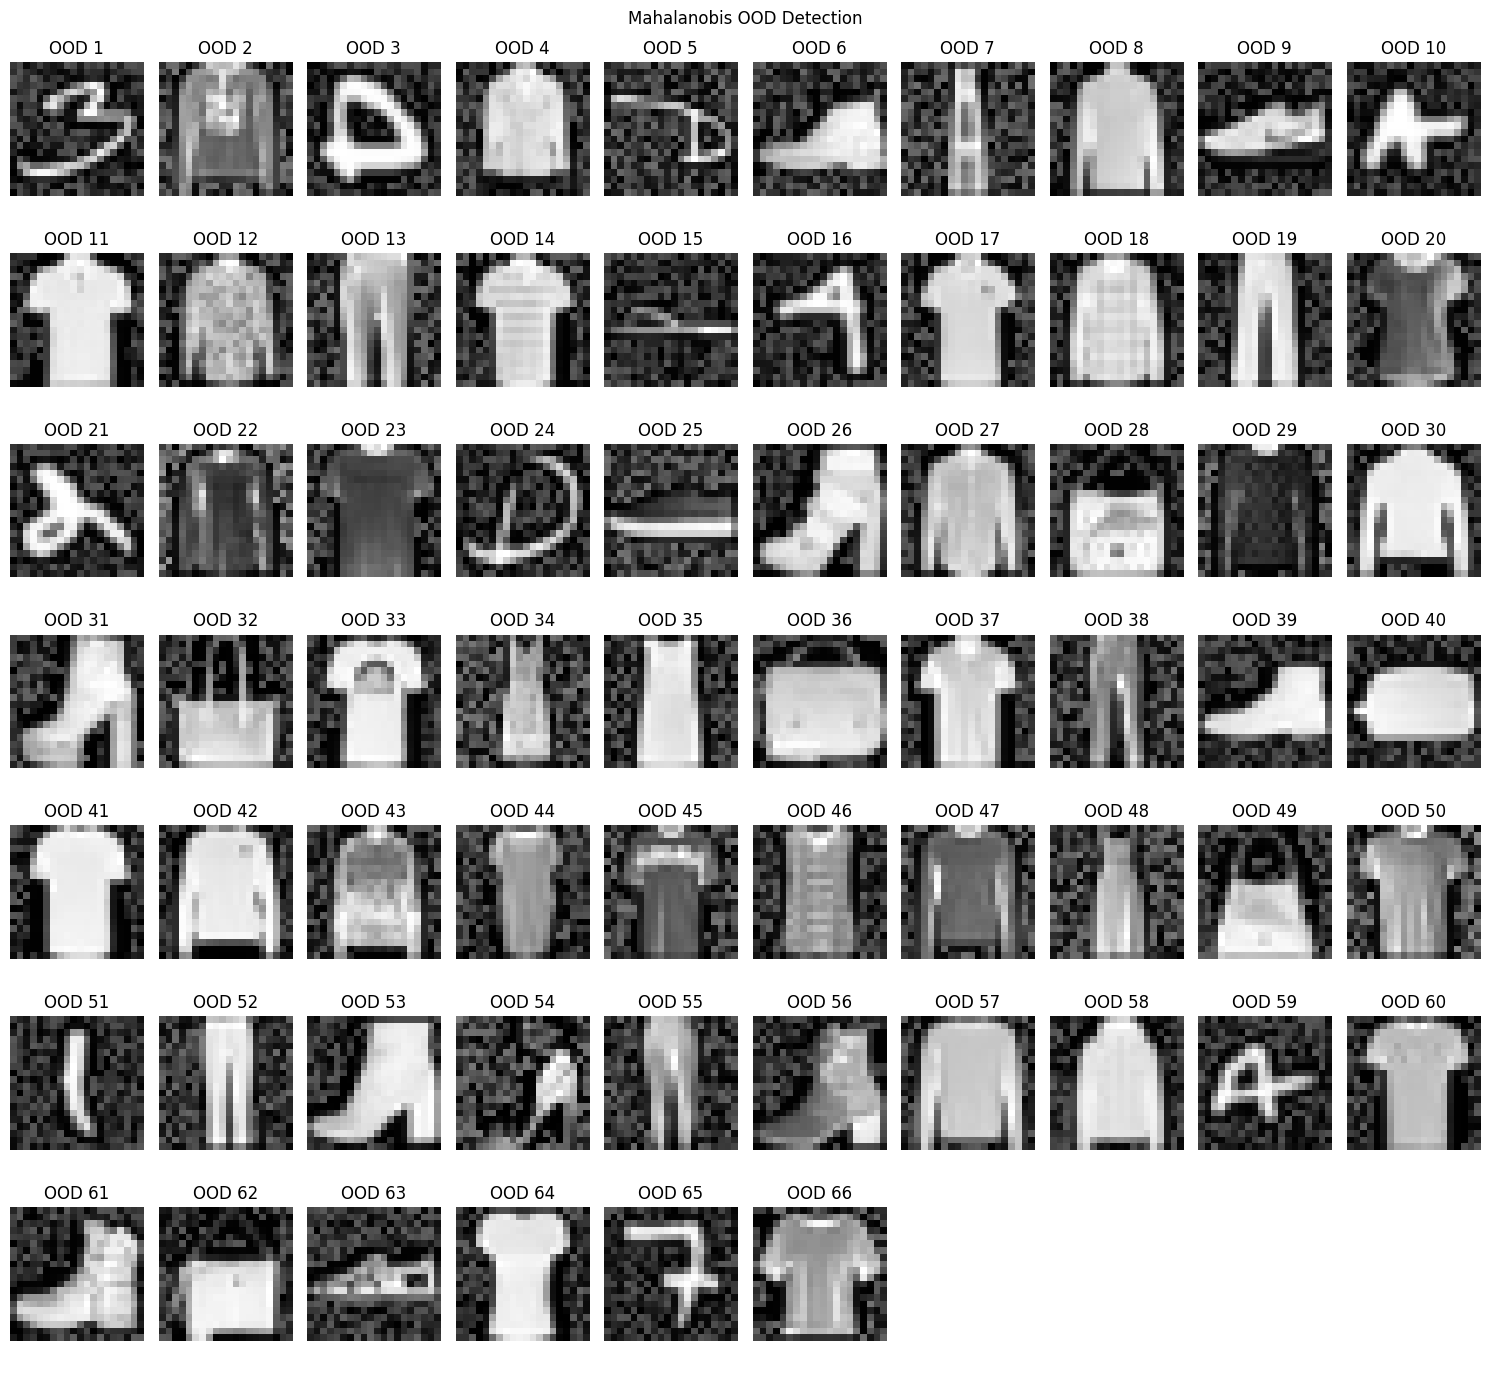

In [22]:
from visiualising import visualize_preds

visualize_preds(X2[g_odd_indices], "Gaussian OOD Detection")
visualize_preds(X2[ood_indices_mahalanobis], "Mahalanobis OOD Detection")